## Import Libraries

In [1]:
# Import libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import mutual_info_regression
import math 
import warnings

# Ignore warnings 

pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

/var/folders/z1/90rjsj_j4t53rc9v54dnwpq00000gp/T/ipykernel_27740/3363500883.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Read Data 
Read data and save to dataframe. Review shape and drop duplicates. Clean up columns and correct data types.

In [2]:
data = pd.read_csv("healthcare_dataset.csv")

data.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [3]:
# Data shape before dropping duplicates 

data.shape

(55500, 15)

In [4]:
# Drop duplicates 

df = data.drop_duplicates()

In [5]:
# Shape after duplicates 

df.shape

(54966, 15)

In [6]:
# Save columns with correct data type 

df['Gender'] = df['Gender'].astype('string')
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])
df['Inpatient Days']= (df['Discharge Date'] - df['Date of Admission']).dt.days+1
df["Admission Year"]=df["Date of Admission"].dt.year
df["Admission Month"]=df["Date of Admission"].dt.month

In [7]:
# Calculate per day Expense 

df = df[df['Billing Amount'] > 0]
df["Per Day Amount"]=df["Billing Amount"]/df["Inpatient Days"]
df["Log Per Day Amount"] = np.log(df["Per Day Amount"])

## Feature Selection 

In [8]:
other_variables = list(df.columns)  # Convert Index to a list
other_variables.remove('Billing Amount')
other_variables.remove('Per Day Amount')
other_variables.remove('Log Per Day Amount')
other_variables.remove('Inpatient Days')
other_variables.remove('Admission Year')
other_variables.remove('Admission Month')
other_variables.remove('Room Number')
other_variables.remove('Age')
other_variables.remove('Name')

independent_vars = ['Billing Amount']

In [9]:
from sklearn.preprocessing import LabelEncoder

# Function to calculate mutual information between two variables
def calculate_mutual_info(X, y):
    mi = mutual_info_regression(X, y)
    return mi

# Initialize a dictionary to store mutual information values
mutual_info_dict = {}

# Convert categorical variables in 'other_variables' to numeric
encoded_data = data.copy()
for col in other_variables:
    if encoded_data[col].dtype == 'object':
        encoded_data[col] = LabelEncoder().fit_transform(encoded_data[col])

# Calculate mutual information for each pair of variables
for var1 in independent_vars:
    for var2 in other_variables:
        X = encoded_data[[var1]]
        y = encoded_data[var2]
        mutual_info = calculate_mutual_info(X, y)
        mutual_info_dict[(var1, var2)] = mutual_info[0]  # Get the scalar value

# Convert the dictionary to a DataFrame for easier analysis
mutual_info_df = pd.DataFrame(list(mutual_info_dict.items()), columns=['Variable Pair', 'Mutual Information'])

# Display the results
mutual_info_df = mutual_info_df.sort_values(by="Mutual Information", ascending=False).reset_index(drop=True)

# Display the sorted DataFrame
mutual_info_df

,Variable Pair,Mutual Information
0,"(Billing Amount, Hospital)",0.102015
1,"(Billing Amount, Doctor)",0.101942
2,"(Billing Amount, Discharge Date)",0.099956
3,"(Billing Amount, Date of Admission)",0.098602
4,"(Billing Amount, Blood Type)",0.080415
5,"(Billing Amount, Medical Condition)",0.065366
6,"(Billing Amount, Medication)",0.065102
7,"(Billing Amount, Insurance Provider)",0.061977
8,"(Billing Amount, Admission Type)",0.048066
9,"(Billing Amount, Test Results)",0.046839


## Models 

In [11]:
df_new = df.drop(columns=['Name', 'Inpatient Days', 'Admission Year', 'Admission Month', 'Room Number', 'Age', 'Gender', 'Test Results', 
                                   'Admission Type', 'Insurance Provider', 'Medication', 'Medical Condition'])

In [13]:
# Define the selected columns and target variable
# selected_columns = ['Blood Type', 'Date of Admission', 'Doctor', 'Hospital',
#                     'Per Day Amount', 'Log Per Day Amount']

selected_columns = ['Blood Type', 'Discharge Date', 'Date of Admission', 'Doctor', 'Hospital']

target = 'Billing Amount'

# Encode categorical variables
data_encoded = df_new.copy()
for col in ['Blood Type', 'Doctor', 'Hospital']:
    data_encoded[col] = LabelEncoder().fit_transform(data_encoded[col])

# Convert dates to numerical features (e.g., timestamp)
data_encoded['Date of Admission'] = pd.to_datetime(data_encoded['Date of Admission']).astype(int) / 10**9
data_encoded['Discharge Date'] = pd.to_datetime(data_encoded['Discharge Date']).astype(int) / 10**9

# Define features (X) and target (y)
X = data_encoded[selected_columns]
y = data_encoded[target]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [14]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_lr = linear_model.predict(X_test)


# Evaluate Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)

mean_actual = y_test.mean()
accuracy_mae = 1 - (mae_lr / mean_actual)
accuracy_rmse = 1 - (rmse_lr / mean_actual)

print("Linear Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.2f}")
print(f"R-squared (R²): {r2_lr:.2f}")
print(f"")
print(f"Accuracy based on MAE (Linear Regression): {accuracy_mae:.2f}")
print(f"Accuracy based on RMSE (Linear Regression): {accuracy_rmse:.2f}")

Linear Regression Performance:
Mean Absolute Error (MAE): 12266.73
Mean Squared Error (MSE): 200770197.60
Root Mean Squared Error (RMSE): 14169.34
R-squared (R²): -0.00

Accuracy based on MAE (Linear Regression): 0.52
Accuracy based on RMSE (Linear Regression): 0.45


### KNN

In [15]:
# K-Nearest Neighbors Regression
knn_model = KNeighborsRegressor(n_neighbors=6) 
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# Evaluate K-Nearest Neighbors Regression
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = mean_squared_error(y_test, y_pred_knn, squared=False)
r2_knn = r2_score(y_test, y_pred_knn)

mean_actual = y_test.mean()
accuracy_mae_KNN = 1 - (mae_knn / mean_actual)
accuracy_rmse_KNN = 1 - (rmse_knn / mean_actual)

print("KNN Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae_knn:.2f}")
print(f"Mean Squared Error (MSE): {mse_knn:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_knn:.2f}")
print(f"R-squared (R²): {r2_knn:.2f}")
print(f"")
print(f"Accuracy based on MAE (KNN): {accuracy_mae_KNN:.2f}")
print(f"Accuracy based on RMSE (KNN): {accuracy_rmse_KNN:.2f}")




KNN Regression Performance:
Mean Absolute Error (MAE): 12733.72
Mean Squared Error (MSE): 228114134.16
Root Mean Squared Error (RMSE): 15103.45
R-squared (R²): -0.14

Accuracy based on MAE (KNN): 0.50
Accuracy based on RMSE (KNN): 0.41


### Random Forest

In [16]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

RF_model = RandomForestRegressor(n_estimators=100, random_state=42)
RF_model.fit(X_train, y_train)
y_pred_RF = RF_model.predict(X_test)

# Evaluate K-Nearest Neighbors Regression
mse_RF = mean_squared_error(y_test, y_pred_RF)
mae_RF = mean_absolute_error(y_test, y_pred_RF)
rmse_RF = mean_squared_error(y_test, y_pred_RF, squared=False)
r2_RF = r2_score(y_test, y_pred_RF)

mean_actual = y_test.mean()
accuracy_mae_RF = 1 - (mae_RF / mean_actual)
accuracy_rmse_RF = 1 - (rmse_RF / mean_actual)

print("Random Forest Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae_RF:.2f}")
print(f"Mean Squared Error (MSE): {mse_RF:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_RF:.2f}")
print(f"R-squared (R²): {r2_RF:.2f}")
print(f"")
print(f"Accuracy based on MAE (KNN): {accuracy_mae_RF:.2f}")
print(f"Accuracy based on RMSE (KNN): {accuracy_rmse_RF:.2f}")

Random Forest Regression Performance:
Mean Absolute Error (MAE): 11349.42
Mean Squared Error (MSE): 186744683.33
Root Mean Squared Error (RMSE): 13665.46
R-squared (R²): 0.07

Accuracy based on MAE (KNN): 0.56
Accuracy based on RMSE (KNN): 0.46


### Gradient Boosting

In [17]:
# Gradient Boosting Regression
from sklearn.ensemble import GradientBoostingRegressor

GB_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
GB_model.fit(X_train, y_train)
y_pred_GB = GB_model.predict(X_test)

# Evaluate K-Nearest Neighbors Regression
mse_GB = mean_squared_error(y_test, y_pred_GB)
mae_GB = mean_absolute_error(y_test, y_pred_GB)
rmse_GB = mean_squared_error(y_test, y_pred_GB, squared=False)
r2_GB = r2_score(y_test, y_pred_GB)

mean_actual = y_test.mean()
accuracy_mae_GB = 1 - (mae_GB / mean_actual)
accuracy_rmse_GB = 1 - (rmse_GB / mean_actual)

print("Gradient Boosting Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae_GB:.2f}")
print(f"Mean Squared Error (MSE): {mse_GB:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_GB:.2f}")
print(f"R-squared (R²): {r2_GB:.2f}")
print(f"")
print(f"Accuracy based on MAE (KNN): {accuracy_mae_GB:.2f}")
print(f"Accuracy based on RMSE (KNN): {accuracy_rmse_GB:.2f}")

Gradient Boosting Regression Performance:
Mean Absolute Error (MAE): 12261.77
Mean Squared Error (MSE): 200833725.16
Root Mean Squared Error (RMSE): 14171.58
R-squared (R²): -0.00

Accuracy based on MAE (KNN): 0.52
Accuracy based on RMSE (KNN): 0.45


## Jin's Code

In [22]:
df = df.drop(columns=["Name","Date of Admission","Doctor","Room Number","Discharge Date","Hospital","Doctor"])

In [23]:
df

,Age,Gender,Blood Type,Medical Condition,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,Inpatient Days,Admission Year,Admission Month,Per Day Amount,Log Per Day Amount
0,30,Male,B-,Cancer,Blue Cross,18856.281306,Urgent,Paracetamol,Normal,3,2024,1,6285.427102,8.745989
1,62,Male,A+,Obesity,Medicare,33643.327287,Emergency,Ibuprofen,Inconclusive,7,2019,8,4806.189612,8.477660
2,76,Female,A-,Obesity,Aetna,27955.096079,Emergency,Aspirin,Normal,16,2022,9,1747.193505,7.465766
3,28,Female,O+,Diabetes,Medicare,37909.782410,Elective,Ibuprofen,Abnormal,31,2020,11,1222.896207,7.108977
4,43,Female,AB+,Cancer,Aetna,14238.317814,Urgent,Penicillin,Abnormal,21,2022,9,678.015134,6.519170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55495,42,Female,O+,Asthma,Blue Cross,2650.714952,Elective,Penicillin,Abnormal,31,2020,8,85.506934,4.448597
55496,61,Female,AB-,Obesity,Cigna,31457.797307,Elective,Aspirin,Normal,10,2020,1,3145.779731,8.053817
55497,38,Female,B+,Hypertension,UnitedHealthcare,27620.764717,Urgent,Ibuprofen,Abnormal,29,2020,7,952.440163,6.859027
55498,43,Male,O-,Arthritis,Medicare,32451.092358,Elective,Ibuprofen,Abnormal,7,2019,5,4635.870337,8.441579


In [9]:
df_cat = pd.DataFrame(data = df.dtypes, columns = ['a']).reset_index()
cat_var = list(df_cat['index'].loc[df_cat['a'] == 'object'])
df_cat = df[cat_var]

In [10]:
cat_var

['Gender',
 'Blood Type',
 'Medical Condition',
 'Insurance Provider',
 'Admission Type',
 'Medication',
 'Test Results']

In [11]:
x_var = ['Gender',
 'Blood Type',
 'Medical Condition',
 'Insurance Provider',
 'Admission Type',
 'Medication',
 'Test Results',
 'Age',
 'Inpatient Days',
 'Admission Month']

<function matplotlib.pyplot.show(close=None, block=None)>

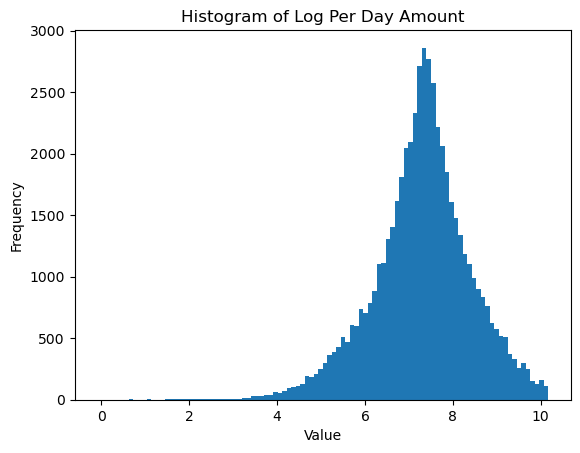

In [12]:
plt.hist(df["Log Per Day Amount"], bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Log Per Day Amount')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

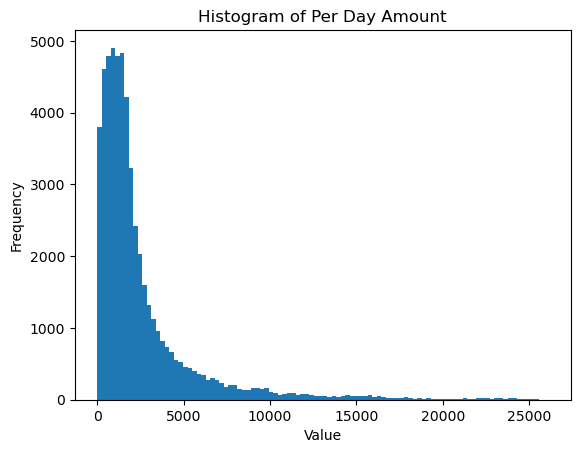

In [13]:

plt.hist(df["Per Day Amount"], bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Per Day Amount')
plt.show

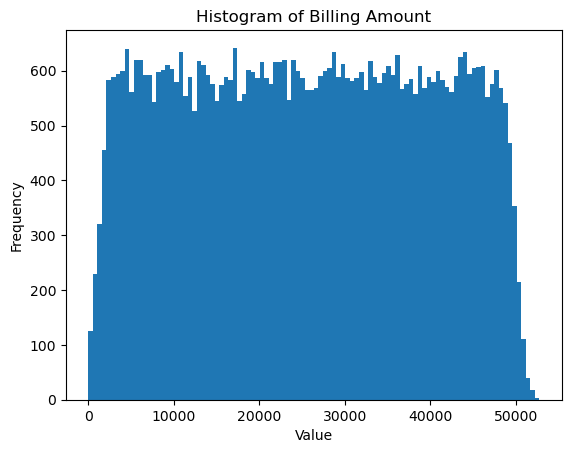

In [14]:
plt.hist(df["Billing Amount"], bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Billing Amount')
plt.show()

In [17]:
# Turn Per day Amount into category
bins = [0,500,1000,2000,3000,4000,5000,7500,10000]
df['Amount Group'] = np.digitize(df["Per Day Amount"], bins)

In [18]:
Y=df['Amount Group']

In [19]:
label_encoder = LabelEncoder()

for col in cat_var:
    df_cat[col] = label_encoder.fit_transform(df_cat[col])

/var/folders/z1/90rjsj_j4t53rc9v54dnwpq00000gp/T/ipykernel_41247/977980751.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[col] = label_encoder.fit_transform(df_cat[col])
/var/folders/z1/90rjsj_j4t53rc9v54dnwpq00000gp/T/ipykernel_41247/977980751.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[col] = label_encoder.fit_transform(df_cat[col])
/var/folders/z1/90rjsj_j4t53rc9v54dnwpq00000gp/T/ipykernel_41247/977980751.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [20]:
X_final = df_cat

In [21]:
inpatient_day = df['Inpatient Days']
age = df['Age']
month = df["Admission Month"]

In [22]:
X_final['Inpatient Days'] = inpatient_day
X_final['Age'] = age 
X_final['Admission Month']=month

/var/folders/z1/90rjsj_j4t53rc9v54dnwpq00000gp/T/ipykernel_41247/3064364617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_final['Inpatient Days'] = inpatient_day
/var/folders/z1/90rjsj_j4t53rc9v54dnwpq00000gp/T/ipykernel_41247/3064364617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_final['Age'] = age
/var/folders/z1/90rjsj_j4t53rc9v54dnwpq00000gp/T/ipykernel_41247/3064364617.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [23]:
X_final

,Gender,Blood Type,Medical Condition,Insurance Provider,Admission Type,Medication,Test Results,Inpatient Days,Age,Admission Month
0,1,5,2,1,2,3,2,3,30,1
1,1,0,5,3,1,1,1,7,62,8
2,0,1,5,0,1,0,2,16,76,9
3,0,6,3,3,0,1,0,31,28,11
4,0,2,2,0,2,4,0,21,43,9
...,...,...,...,...,...,...,...,...,...,...
55495,0,6,1,1,0,4,0,31,42,8
55496,0,3,5,2,0,0,2,10,61,1
55497,0,4,4,4,2,1,0,29,38,7
55498,1,7,0,3,0,1,0,7,43,5


In [24]:
# Splitting the dataset into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(X_final, Y, test_size=0.2, random_state=42)

Training accuracy for Logistic Regression:  0.34111830113014946
Testing accuracy for Logistic Regression:  0.3487969376594969


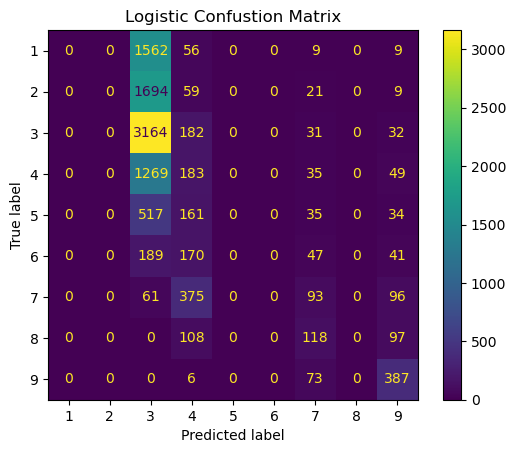

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1636
           2       0.00      0.00      0.00      1783
           3       0.37      0.93      0.53      3409
           4       0.14      0.12      0.13      1536
           5       0.00      0.00      0.00       747
           6       0.00      0.00      0.00       447
           7       0.20      0.15      0.17       625
           8       0.00      0.00      0.00       323
           9       0.51      0.83      0.63       466

    accuracy                           0.35     10972
   macro avg       0.14      0.23      0.16     10972
weighted avg       0.17      0.35      0.22     10972



/Users/andrea.tardif/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrea.tardif/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrea.tardif/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
#Logistic Regression
LOG = LogisticRegression(max_iter=200,solver='liblinear').fit(xtrain, ytrain) 

#training error
log_ypred_train = LOG.predict(xtrain)
log_train_acct=metrics.accuracy_score(ytrain, log_ypred_train)
print("Training accuracy for Logistic Regression: ",log_train_acct)

#testing error
log_ypred_test = LOG.predict(xtest)
log_test_acct=metrics.accuracy_score(ytest, log_ypred_test)
print("Testing accuracy for Logistic Regression: ",log_test_acct)

#confusion matrix 
LOG_Confu = confusion_matrix(ytest, log_ypred_test)
cmtx = confusion_matrix(ytest, log_ypred_test, labels=LOG.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cmtx,display_labels=LOG.classes_)
disp.plot()
plt.title("Logistic Confustion Matrix")
plt.savefig("Log.jpg")
plt.show()


#precision recall F-1 score
print(classification_report(ytest, log_ypred_test))

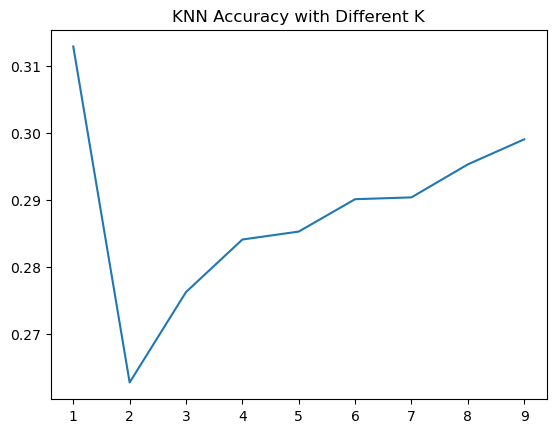

In [26]:
#KNN
#tune k
N_acct=[]
N_K=[]

for i in range(1,10):
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(xtrain, ytrain)
    N_K.append(i)
    ypred_test =KNN.predict(xtest)
    N_acct.append(metrics.accuracy_score(ytest, ypred_test))  
plt.plot(N_K,N_acct)
plt.title("KNN Accuracy with Different K")
plt.savefig("knnk.jpg")

Training accuracy for KNN:  0.5617936565803865
Testing accuracy for KNN:  0.28408676631425445


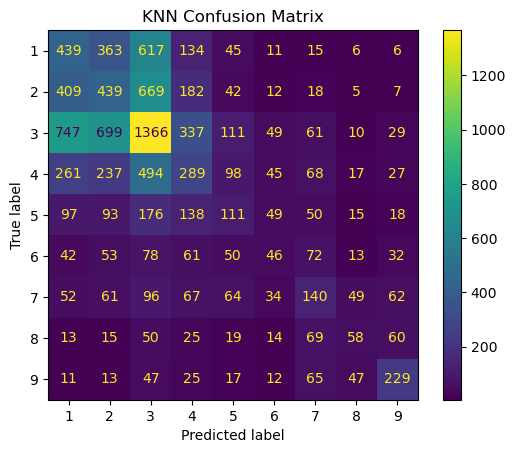

              precision    recall  f1-score   support

           1       0.21      0.27      0.24      1636
           2       0.22      0.25      0.23      1783
           3       0.38      0.40      0.39      3409
           4       0.23      0.19      0.21      1536
           5       0.20      0.15      0.17       747
           6       0.17      0.10      0.13       447
           7       0.25      0.22      0.24       625
           8       0.26      0.18      0.21       323
           9       0.49      0.49      0.49       466

    accuracy                           0.28     10972
   macro avg       0.27      0.25      0.26     10972
weighted avg       0.28      0.28      0.28     10972



In [27]:
#k = 4 has the highst accuracy 
KNN = KNeighborsClassifier(n_neighbors=4)
KNN.fit(xtrain, ytrain)

# traning error
knn_ypred_train = KNN.predict(xtrain)
knn_train_acct=metrics.accuracy_score(ytrain, knn_ypred_train)
print("Training accuracy for KNN: ",knn_train_acct)


#testing error
knn_ypred_test =KNN.predict(xtest)
knn_test_acct=metrics.accuracy_score(ytest, knn_ypred_test)
print("Testing accuracy for KNN: ",knn_test_acct)

#confusion matrix 
KNN_Confu = confusion_matrix(ytest, knn_ypred_test)
cmtx = confusion_matrix(ytest, knn_ypred_test, labels=KNN.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cmtx, display_labels=KNN.classes_)
disp.plot()
plt.title("KNN Confusion Matrix")
#plt.savefig("KNN.jpg")
plt.show()



#precision recall F-1 score
print(classification_report(ytest, knn_ypred_test))